# HARPS-N

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from redcross import Datacube, read_harpsn, Pipeline

### Reading instrument files
Let's read the instrument's pipeline FITS files for each spectrum and create a `Datacube` instance with the correct formatting. 

In this example we place HARPS-N `e2ds` files in the folder `data_dir`.
HARPS-N is an ultra-stabilised spectrograph placed at the 3.6m-TNG telescope with a resolution of **R ~ 115,000**. It works in the **optical range from 400 to 690 nm**.

In [8]:
data_dir = '../../../../../wasp189/harpsn/data/night1/' # change to your own directory
print()
files = sorted(glob.glob(os.path.join(data_dir, '*A.fits'))) # IMPORTANT: sort the files
print('{:} files found!'.format(len(files)))


247 files found!


For HARPS-N, we use the in-built function `read_harpsn`. The function reads all the files and reshapes them to store the data for each order with all frames.
At this stage you may want to define your own function to 
read the *wavelength*, *flux* and the *header* of each frame. The header must be a dictionary and can be passed as a kwarg argument i.e. `dc = Datacube(**header)`. The header keys will automatically be stored as attributes.

In [9]:
dc = read_harpsn(files)
print('\n{:} orders, {:} files, {:} pixel channels\n'.format(*dc.shape))

---> 246 HARPN.2019-04-14T05-32-17.209_e2ds_A.fits
69 orders, 247 files, 4096 pixel channels



### Wavelength solution
Most instrument's pipelines provide a wavelength solution (WS) stored as a vector or as a polynomial in the FITS file. For this example, we take the **WS of each order as the time-average of all the frames** for that order. This works well for *ultra*-stabilised instruments but additional steps to refine the WS might be necessary in some cases.

In [10]:
print('Original wavelength vector shape = {:}'.format(dc.wlt.shape))
dc.wlt = np.median(dc.wlt, axis=1)
print('NEW wavelength vector shape = {:}'.format(dc.wlt.shape))

Original wavelength vector shape = (69, 247, 4096)
NEW wavelength vector shape = (69, 4096)


### Header parameters
The header parameters are optional but it is recommended to pass them when creating the `datacube` instance. Some tools like `airmass_detrend` will only work with required header parameters (airmass).

dict_keys(['flux', 'wlt', 'night', 'airmass', 'MJD', 'BERV', 'RA_DEG', 'DEC_DEG', 'DATE', 'frame'])


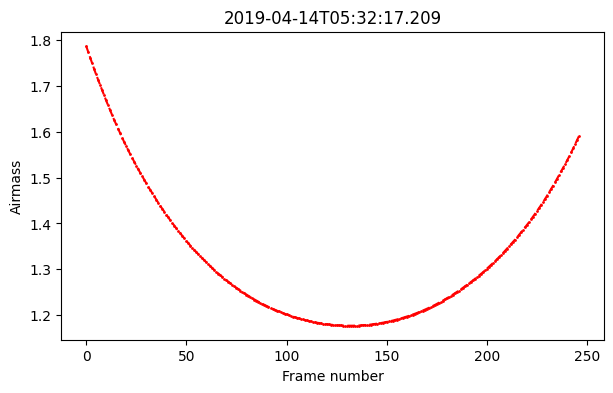

In [11]:
print(vars(dc).keys())
fig, ax = plt.subplots(1, figsize=(7,4))
ax.plot(dc.airmass, '--or', ms=1.)
ax.set(title=dc.DATE, xlabel='Frame number', ylabel='Airmass')
plt.show()

### Reduction pipeline for a single-order
We use the `Pipeline` object to define a set of reduction steps and apply them to every order. First, we play around with the routine by displaying the step-by-step process for a given order. Steps can also be added individually and arguments to the functions can be passed as dictionaries.

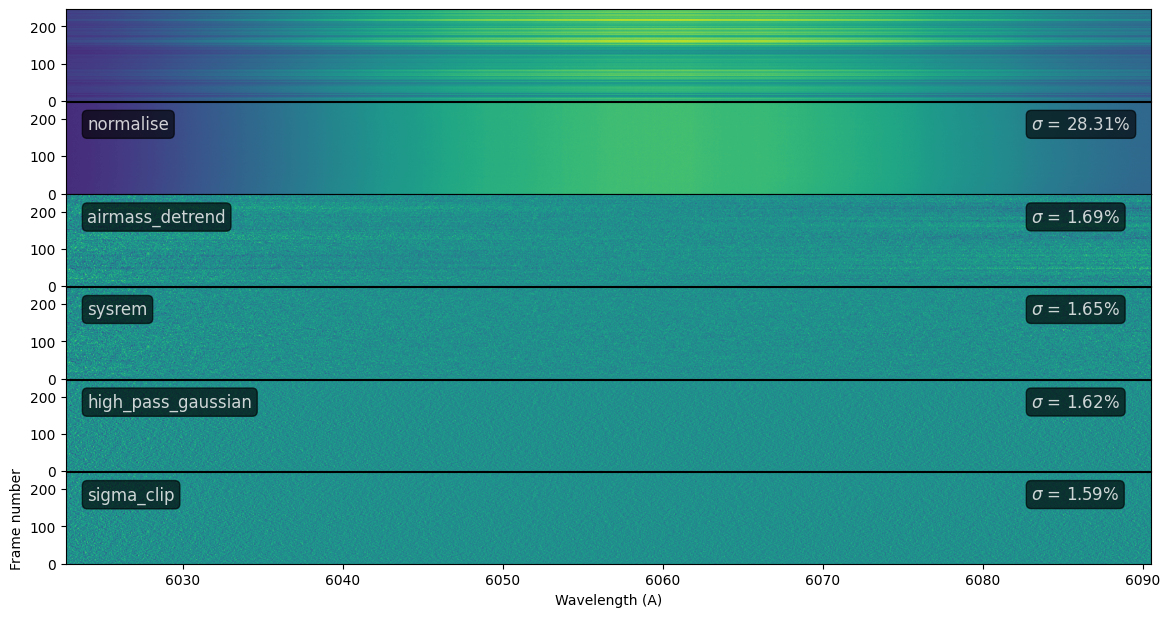

In [12]:
order = 56 # pick order

steps = ['normalise','airmass_detrend']
pipeline = Pipeline(steps)

# Add functions with arguments
pipeline.add('sysrem', {'n':3})
pipeline.add('high_pass_gaussian', {'window':15})
pipeline.add('sigma_clip', {'sigma':3}) 

n = len(steps)+1
fig, ax = plt.subplots(n, figsize=(14, n*1.2))
plt.subplots_adjust(hspace=0.01)
[ax[k].set_xticks([]) for k in range(n-1)]
ax[0].set_title('Reduction for order {:}'.format(order))
ax[len(ax)-1].set(xlabel='Wavelength (A)', ylabel='Frame number')

# Call the Pipeline object to a given order
# pass `ax` to display every step (with len(ax) = len(steps)+1))
pipeline.reduce(order, dc, ax=ax)